# Image Retrieval using Embeddings and a Nearest Neighbour search (ShapeNet)

## Imports

In [47]:
%pip install numpy torch torchvision matplotlib tqdm pillow seaborn

Note: you may need to restart the kernel to use updated packages.


In [48]:
import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, random_split

from torchvision import datasets, transforms
from torchvision.utils import make_grid

from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix

from operator import itemgetter
from PIL import Image
from seaborn import heatmap

### Enable CUDA

In [49]:
device = torch.device("cuda") \
    if torch.cuda.is_available() \
    else torch.device("cpu")
    
print(f"Device: {device}")

Device: cuda


## Dataset

### Utils

In [50]:
mean = torch.tensor([0.0812, 0.0764, 0.0727])
std = torch.tensor([0.1789, 0.1699, 0.1633])

batch_size = 128

def get_image_mean_and_std(dataset):
    loader = DataLoader(dataset, batch_size=batch_size)
    numberof_images = 0
    mean, std = 0, 0

    for batch, _, _ in tqdm.tqdm(loader, unit="batch"):
        batch = batch.view(batch.size(0), batch.size(1), -1)

        numberof_images += batch.size(0)
        mean += batch.mean(2).sum(0) 
        std += batch.std(2).sum(0)

    return mean / numberof_images, std / numberof_images

unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

def denorm(x, channels=None, w=None ,h=None, resize=False):
    x = unnormalize(x)
    
    if resize:
        if channels is None or w is None or h is None:
            print('Number of channels, width and height must be provided for resize.')
        x = x.view(x.size(0), channels, w, h)
    
    return x

def show(image, axis=None):
    numpy_image = image.cpu().numpy()
    if axis is not None:
        axis.imshow(np.transpose(numpy_image, (1,2,0)))
    else:
        plt.imshow(np.transpose(numpy_image, (1,2,0)))

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)                   
])

class_label_lookup = {
    "02691156": "plane", # planes
    "02828884": "bench", # benches
    "02933112": "cupboard", # cupboards/wardrobes
    "02958343": "car", # cars
    "03001627": "chair", # chairs
    "03211117": "computer", # computers
    "03636649": "lamp", # lamps
    "03691459": "speaker", # speakers
    "04090263": "gun", # guns
    "04256520": "sofa", # sofas
    "04379243": "table", # tables/desks
    "04401088": "phone", # phones
    "04530566": "boat"  # boats
}

class ImageFolderWithImagePath(datasets.ImageFolder):
    def __getitem__(self, index):
        image, _ = super().__getitem__(index)
        path = self.imgs[index][0]

        code = path.split("/")[1]
        label = class_label_lookup[code]
        
        return image, label, path

### Load ShapeNet (smaller version for this task)

In [51]:
shapenet_dataset = ImageFolderWithImagePath("ShapeNetReduced/", transform=transform)

In [52]:
mean, std = get_image_mean_and_std(shapenet_dataset)
print(f"Mean: {mean}\nStd. Deviation: {std}")

100%|██████████| 251/251 [01:39<00:00,  2.52batch/s]

Mean: tensor([-0.0002, -0.0002, -0.0002])
Std. Deviation: tensor([1.0255, 1.0263, 1.0270])


### Reducing Dataset Size (testing)

In [53]:
shapenet_size = len(shapenet_dataset)
print(f"Size of ShapeNet: {shapenet_size} images.")

shapenet_reduced_size = shapenet_size // 1
unused_shapenet_size = shapenet_size - shapenet_reduced_size
shapenet_reduced_dataset, _ = random_split(shapenet_dataset, (shapenet_reduced_size, unused_shapenet_size))

print(f"Size of reduced ShapeNet: {len(shapenet_reduced_dataset)} images.")

Size of ShapeNet: 32040 images.
Size of reduced ShapeNet: 32040 images.


### Shuffling and Splitting Dataset

In [54]:
ratios = (0.7, 0.1, 0.2)

sizes = list(map(lambda x: round(len(shapenet_reduced_dataset) * x), ratios))
if sum(sizes) < len(shapenet_reduced_dataset):
      sizes[0] += len(shapenet_reduced_dataset) - sum(sizes)

print(f"Dataset sizes: {tuple(sizes)}")

[train, test, db] = random_split(shapenet_reduced_dataset, sizes)

print(f"Dataset Lengths:"
      f"\n\tTrain: {len(train)},"
      f"\n\tTest: {len(test)},"
      f"\n\tDatabase: {len(db)}")

loader_train = DataLoader(train, batch_size=batch_size)
loader_test = DataLoader(test, batch_size=1)

loader_database = DataLoader(db, batch_size=batch_size)

Dataset sizes: (22428, 3204, 6408)
Dataset Lengths:
	Train: 22428,
	Test: 3204,
	Database: 6408


## Model

In [55]:
class AutoEncoderModel(nn.Module):
    def __init__(self, latent_size):
        super().__init__()
        
        self.latent_size = latent_size
        self.fc_size = 1024

        self.encoder = nn.Sequential(
            # Input is 128 x 128 x 3, Output is 1 x 1 x 1024
            nn.Conv2d(in_channels=3, out_channels=64, 
                      kernel_size=3, padding=1,
                      stride=2, bias=False), # 64 x 64 x 64
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, 
                      kernel_size=3, padding=1,
                      stride=2, bias=False), # 32 x 32 x 128
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=256, 
                      kernel_size=3, padding=1,
                      stride=2, bias=False), # 16 x 16 x 256
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=512,
                      kernel_size=3, padding=1,
                      stride=2, bias=False), # 8 x 8 x 512
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512,
                      out_channels=self.fc_size,
                      kernel_size=3, padding=1,
                      stride=2, bias=False), # 4 x 4 x 1024
            nn.BatchNorm2d(self.fc_size),
            nn.AvgPool2d(4), # 1 x 1 x 1024
            nn.ReLU(inplace=True)
        )
        
        self.encoder_mu = nn.Linear(in_features=self.fc_size, 
                                    out_features=self.latent_size)

        self.encoder_var = nn.Linear(in_features=self.fc_size,
                                     out_features=self.latent_size)

        self.decoder_fc = nn.Linear(in_features=self.latent_size, 
                                    out_features=self.fc_size)

        self.decoder = nn.Sequential(
            # Input is 1 x 1 x 1024, Output is 128 x 128 x 3
            nn.ConvTranspose2d(in_channels=self.fc_size,
                               out_channels=self.fc_size,
                               kernel_size=4), # 4 x 4 x 1024
            nn.BatchNorm2d(self.fc_size),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=self.fc_size,
                               out_channels=512,
                               kernel_size=4, padding=1,
                               stride=2), # 8 x 8 x 512
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=512, out_channels=256,
                               kernel_size=4, padding=1,
                               stride=2), # 16 x 16 x 256
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=256,
                               out_channels=128,
                               kernel_size=4, padding=1,
                               stride=2), # 32 x 32 x 128
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=128,
                               out_channels=64,
                               kernel_size=4, padding=1,
                               stride=2), # 64 x 64 x 64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64,
                               out_channels=3,
                               kernel_size=4, padding=1,
                               stride=2), # 128 x 128 x 3
            nn.Tanh()
        )

        initial_scale = torch.tensor([1], dtype=torch.float, device=device)
        self.scale = nn.Parameter(initial_scale, requires_grad=True)
        
        self.register_parameter(name="scale", param=self.scale)
        
    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)

        mean = self.encoder_mu(x)
        logvar = self.encoder_var(x)

        return mean, logvar
    
    def reparametrize(self, mu, logvar):
        return mu + torch.rand_like(mu).mul(torch.exp(logvar / 2))

    def decode(self, z):
        z = self.decoder_fc(z)
        z = z.view(z.size(0), self.fc_size, 1, 1)
        
        return self.decoder(z) * self.scale
    
    def forward(self, x):
        mu, logvar = self.encode(x)

        z = mu if not self.training \
            else self.reparametrize(mu, logvar)

        reconstruction = self.decode(z)
        return reconstruction, mu, logvar


## Search Algorithm

In [56]:
def cosine_similarity(a: np.ndarray, b: np.ndarray):
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))

def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

def similarity_metric(target, embedding):
    vector, label, path = embedding
    return cosine_similarity(target, vector), label, path

def get_similarities(target_image, embeddings):
    target_image_transformed = target_image.unsqueeze(0).to(device)
    mean, _ = model.encode(target_image_transformed)
    target_embedding = mean.squeeze(0).cpu().detach().numpy()
    
    similarity = map(lambda x: similarity_metric(target_embedding, x), embeddings)
    return sorted(similarity, key=itemgetter(0), reverse=True)

def get_closest_match(target_image, embeddings):
    return get_similarities(target_image, embeddings)[0]

## Training

### Hyperparameters

In [57]:
num_epochs = 30
learning_rate = 5e-4
batch_size = 128
beta = 0.3
image_size = 64
weight_decay = 1e-9
latent_size = 100

### Loss Function

In [58]:
def vae_loss(recon_x, x, mu, logvar, beta):
	x_reshaped = x.view(-1, image_size ** 2)
	recon_x_reshaped = recon_x.view(-1, image_size ** 2)

	loss = F.mse_loss(recon_x_reshaped, x_reshaped, reduction="sum")
	divergence = torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / 2

	return loss - (beta * divergence)

### Initialisation

In [59]:
model = AutoEncoderModel(latent_size).to(device)

optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate, 
                             weight_decay=weight_decay)

### Sample Data

/usr/local/lib/python3.9/dist-packages/torchvision/utils.py:68: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Dimensions of a batch: torch.Size([128, 3, 128, 128])


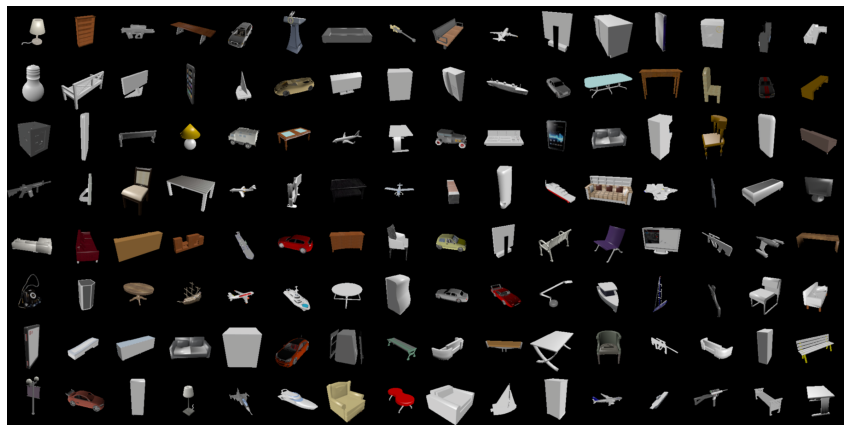

In [71]:
samples, _, _ = next(iter(loader_database))

print(f"Dimensions of a batch: {samples.shape}")

samples = unnormalize(samples.cpu())
samples = make_grid(samples, nrow=16, padding=0, normalize=False,
                    range=None, scale_each=False, pad_value=0)

plt.figure(figsize=(15,15))
plt.axis('off')

show(samples)

### Training Loop

In [61]:
report_every = 20
epoch_losses = list()

model.train()

for epoch in range(num_epochs):
	epoch_loss = 0
	num_batches = 0

	with tqdm.tqdm(loader_train, unit="batch") as tepoch:
		tepoch.set_description(f"Epoch {epoch+1}")

		for i, (images, _, _) in enumerate(tepoch):   
			optimiser.zero_grad()
			images = images.to(device)

			reconstruction, mu, logvar = model(images)
			loss = vae_loss(reconstruction, images, mu, logvar, beta)

			loss.backward()
			optimiser.step()

			epoch_loss += loss.item()
			num_batches += 1

			training_loss = loss.item() / len(images)
			tepoch.set_postfix(loss=training_loss)

	epoch_losses.append(epoch_loss / num_batches)

Epoch 30: 100%|██████████| 176/176 [00:38<00:00,  4.54batch/s, loss=7.52e+3]


## Evaluation

In [62]:
model.eval()

AutoEncoderModel(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(1024, eps=1e-05, mo

### Reconstructions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Dimensions of a batch: (128, 3, 128, 128)


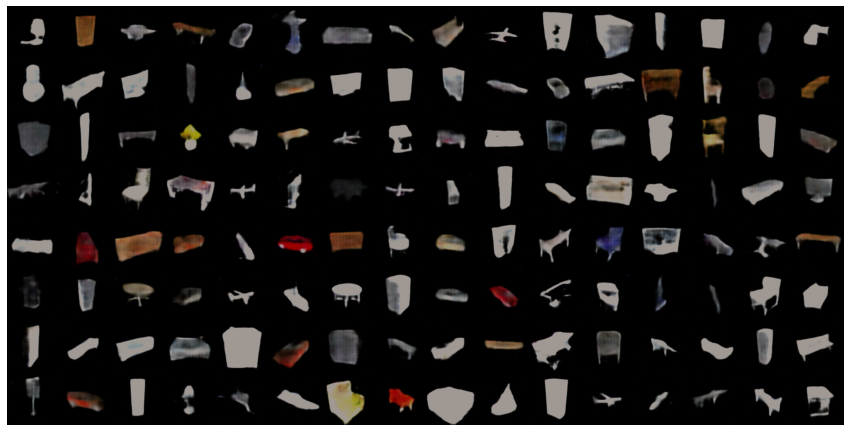

In [63]:
samples, _, _ = next(iter(loader_database))

print(f"Dimensions of a batch: {tuple(samples.shape)}")

reconstruction, _, _ = model(samples.to(device))
reconstruction = unnormalize(reconstruction.cpu())

reconstruction = make_grid(reconstruction, nrow=16, padding=0, 
                           normalize=False, range=None, 
                           scale_each=False, pad_value=0)

plt.figure(figsize=(15,15))
plt.axis('off')

show(reconstruction)

### t-SNE Plot

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


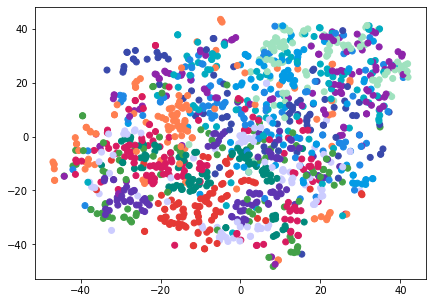

In [70]:
label_colour_lookup = {
    "plane": "#E53935", # planes
    "bench": "#D81B60", # benches
    "cupboard": "#8E24AA", # cupboards/wardrobes
    "car": "#5E35B1", # cars
    "chair": "#3949AB", # chairs
    "computer": "#1E88E5", # computers
    "lamp": "#039BE5", # lamps
    "speaker": "#00ACC1", # speakers
    "gun": "#00897B", # guns
    "sofa": "#43A047", # sofas
    "table": "#FF7F50", # tables/desks
    "phone": "#9FE2BF", # phones
    "boat": "#CCCCFF"  # boats
}

batches = list()
z_colours = list()

batch_iterable = iter(loader_database)

for _ in range(10):
    images, labels, paths = next(batch_iterable)
    mean, _ = model.encode(images.to(device))
    z = mean.cpu().detach().numpy()

    z_colours.extend(list(map(label_colour_lookup.get, labels)))

    batches.append(z)

z = np.vstack(tuple(batches))

z_reduced = TSNE(init="pca", learning_rate="auto").fit_transform(z)
z_reduced_x, z_reduced_y = zip(*z_reduced)

figure, axis = plt.subplots()
figure.set_size_inches(7, 5)

axis.scatter(list(z_reduced_x), list(z_reduced_y), c=z_colours)

## Query Test

### Create Embeddings Database

In [65]:
embeddings_database = list()

for images, labels, paths in tqdm.tqdm(loader_database, unit="batch"):
    mu, _ = model.encode(images.to(device))
    embeddings = mu.cpu().detach().numpy()
    embeddings_database.extend(list(zip(embeddings, labels, paths)))

100%|██████████| 51/51 [00:08<00:00,  6.04batch/s]


In [66]:
test_embedding, test_label, test_path = embeddings_database[0]
print(test_embedding.shape, test_label, test_path)

(100,) lamp ShapeNetReduced/03636649/4fe9a79b382d30fb1735ea0e092a805a/rendering/09.png


### Run Query

Similarity (closest image 1): 0.7300 (table)


/usr/local/lib/python3.9/dist-packages/torchvision/utils.py:68: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Similarity (closest image 2): 0.7210 (table)
Similarity (closest image 3): 0.7114 (table)
Similarity (closest image 4): 0.7024 (table)
Similarity (closest image 5): 0.7013 (table)
Similarity (furthest image 1): -0.4183 (boat)
Similarity (furthest image 2): -0.4239 (cupboard)
Similarity (furthest image 3): -0.4289 (boat)
Similarity (furthest image 4): -0.4388 (boat)
Similarity (furthest image 5): -0.4427 (boat)


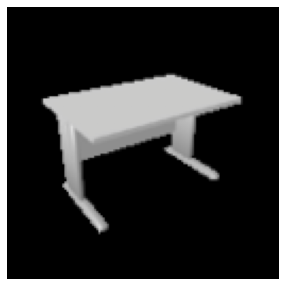

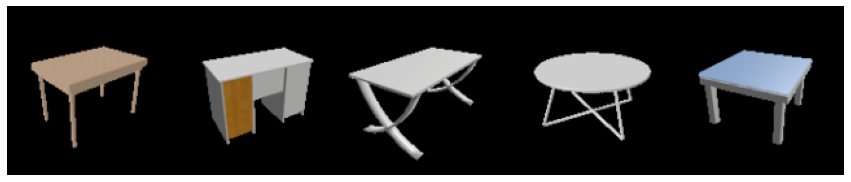

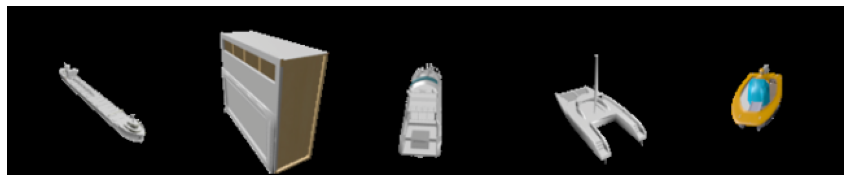

In [67]:
target, _, _ = random.choice(loader_test.dataset)
results = get_similarities(target, embeddings_database)

figure, axis = plt.subplots()
figure.set_size_inches(5, 5)
axis.set_axis_off()

show(unnormalize(target), axis=axis)

good_matches = list()

for i, (similarity, label, path) in enumerate(results[:5]):
    print(f"Similarity (closest image {i+1}): {similarity:.4f} ({label})")
    image = Image.open(path).convert("RGB")
    image = unnormalize(transform(image)).unsqueeze(0)

    good_matches.append(image.cpu())

good_matches = torch.vstack(good_matches)
good_matches = make_grid(good_matches, nrow=5, padding=1, normalize=False,
                         range=None, scale_each=False, pad_value=0)

good_figure, good_axis = plt.subplots()
good_figure.set_size_inches(15, 15)
good_axis.set_axis_off()

show(good_matches, axis=good_axis)

bad_matches = list()

for i, (similarity, label, path) in enumerate(results[-5:]):
    print(f"Similarity (furthest image {i+1}): {similarity:.4f} ({label})")
    image = Image.open(path).convert("RGB")
    image = unnormalize(transform(image)).unsqueeze(0)

    bad_matches.append(image.cpu())

bad_matches = torch.vstack(bad_matches)
bad_matches = make_grid(bad_matches, nrow=5, padding=1, normalize=False,
                        range=None, scale_each=False, pad_value=0)

bad_figure, bad_axis = plt.subplots()
bad_figure.set_size_inches(15, 15)
bad_axis.set_axis_off()

show(bad_matches, axis=bad_axis)

### Accuracy (using class labels)

In [68]:
def confusion(predictions, ground_truth, labels):
  cm = confusion_matrix(np.array(ground_truth), np.array(predictions), normalize='true')

  figure, axis = plt.subplots()
  heatmap(cm, annot=True, ax=axis)

  axis.set_xlabel('Predicted labels')
  axis.set_ylabel('True labels')
  axis.set_title('Confusion Matrix')

  axis.xaxis.set_ticklabels(labels, rotation=70)
  axis.yaxis.set_ticklabels(labels, rotation=0);

  figure.set_size_inches(12, 10)

  plt.show()

def check_accuracy(loader, labels):
	numberof_correct = 0
	numberof_samples = 0

	loader_labels = list()
	nearest_labels = list()

	with torch.no_grad():
		for image, label, _ in loader:
			label = label[0]
			image = image.to(device).squeeze()
			_, nearest_label, _ = get_closest_match(image, embeddings_database)
			
			numberof_correct += int(nearest_label == label)
			numberof_samples += 1
			
			loader_labels.append(labels.index(label))
			nearest_labels.append(labels.index(nearest_label))

		accuracy = numberof_correct / numberof_samples

		print(f"Got {numberof_correct} / {numberof_samples} correct ({100 * accuracy:.2f}%)")

		confusion(nearest_labels, loader_labels, labels)

Got 2437 / 3204 correct (76.06%)


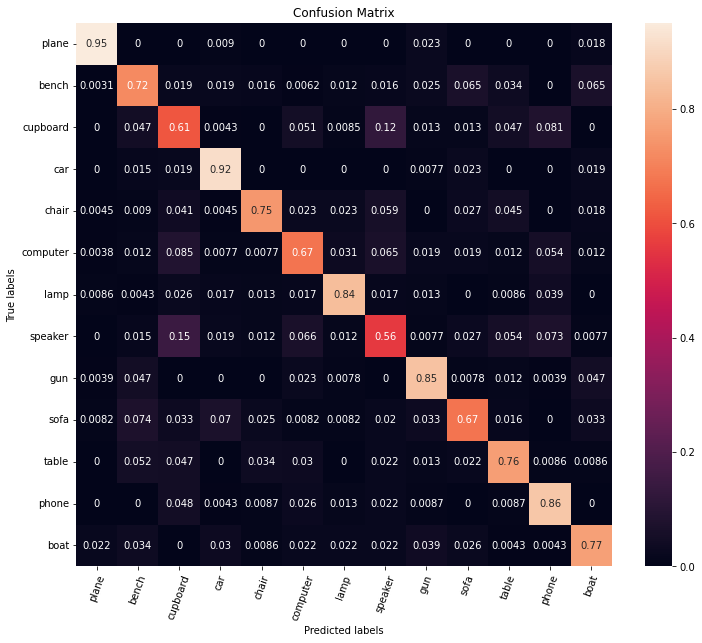

In [69]:
labels = list(class_label_lookup.values())
check_accuracy(loader_test, labels)